# Project goal

To examine time series data on players drafted that reach the Major Leagues to see whether there are any demonstrable shifts relative to previous years that could give insight into the negatively trending attendance per game.

In [1]:
## Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pd.options.mode.chained_assignment = None
import dc_stat_think as dcst

# Player data

All player data was scraped from The Baseball Cube, which has information on players as far back as the late 1800's. The code for the scrape can be found on my GitHub (https://github.com/jordanbean/Project_Quality)

In [2]:
## Read in the first scraped dataset

df_players = pd.read_csv(r'C:\Users\jbean\Dropbox\Other\Python\baseballdatabank-2017.1\Project_Quality\player_scrape.csv', index_col = 'index')

df_games = pd.DataFrame()
    
print(df_players.sample(7))

                      current_org        draft_info mlb_career  \
index                                                            
13284                         NaN               NaN  1911-1920   
4173                          NaN  1964-   UDFA-LAN  1967-1971   
12487                         NaN               NaN  1935-1936   
1804                          NaN               NaN  1915-1925   
6197                          NaN               NaN  1925-1927   
3192                          NaN  1965-   UDFA-NYA  1966-1973   
1190   Washington Nationals (MLB)  1996-   UDFA-TEX  2001-2017   

          player_name position date_of_birth  
index                                         
13284   Gene Paulette    1B-2B    1891-05-26  
4173       Tommy Dean       SS     8/30/1945  
12487   Emmett Nelson        P     2/26/1905  
1804       Neal Brady        P    1897-03-04  
6197        Joe Giard        P    1898-10-07  
3192       Al Closter        P     6/15/1943  
1190   Joaquin Benoit        

In [3]:
## Filter for only the players that were marked as drafted (Format: Year-round-pick number-team) or Undrafted
## Free Agents (Format: Year-UDFA-Team)

df_drafted_info = df_players.dropna(subset=['draft_info'])

df_drafted_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10143 entries, 0 to 19159
Data columns (total 6 columns):
current_org      1583 non-null object
draft_info       10143 non-null object
mlb_career       10143 non-null object
player_name      10143 non-null object
position         10143 non-null object
date_of_birth    10143 non-null object
dtypes: object(6)
memory usage: 554.7+ KB


In [4]:
## Data cleaning on year born column; extract just the year

df_drafted_info['date_of_birth'] = pd.to_datetime(df_drafted_info['date_of_birth'])

df_drafted_info['year_born'] = df_drafted_info['date_of_birth'].dt.year

In [5]:
## Data cleaning on mlb_career column; split into year start and year end and convert values to integers

df_drafted_info['mlb_start'] = [i.split('-')[0] for i in df_drafted_info['mlb_career']]
df_drafted_info['mlb_end'] = [i.split('-')[1] for i in df_drafted_info['mlb_career']]

df_drafted_info['mlb_start'] = df_drafted_info['mlb_start'].astype(int)
df_drafted_info['mlb_end'] = df_drafted_info['mlb_end'].astype(int)

In [6]:
## Data cleaning on draft_info column
## Define a function that determines which string type the value is (UDFA or Drafted) and parses appropriately
## to give the year the player was drafted, the round drafted in, overall pick, and the team that drafted them.
## Separately, we'll also add a dummy variable (1 or 0) for whether they were an undrafted free agent (UDFA)

udfa_dummy = []

for word in df_drafted_info['draft_info']:
    
    if 'UDFA' in word:
            udfa_dummy.append(1)
            
    else:
        udfa_dummy.append(0)

df_drafted_info['udfa_dummy'] = udfa_dummy

def clean_draftinfo(srs):
    
    draft_year = []
    draft_round = []
    draft_number = []
    draft_team = []  
 
    for word in srs:
        
        if 'UDFA' in word:
            
            word = word.split('-')
            draft_year.append(word[0])
            draft_round.append(0) # Assign 0 to draft round number for undrafted free agents
            draft_number.append(0) # Assign 0 to draft number for undrafted free agents
            draft_team.append(word[2])
            
        else:
            
            word = word.split('-')
            draft_year.append(word[0])
            draft_round.append(word[1])
            draft_number.append(word[2])
            draft_team.append(word[3])
            
    def elim_whitespace(series): # Take out unneccessary characters
        
        series = [str(i).strip() for i in series]
        
        return series
    
    for i in [draft_year, draft_round, draft_number, draft_team]:
        
        i = elim_whitespace(i)
        
    def convert_vals(lst): # Convert numerical values to integers
        
        lst = [int(i) for i in lst]
        
        return lst 
    
    draft_year = convert_vals(draft_year)
    draft_round = convert_vals(draft_round)
    draft_number = convert_vals(draft_number)
        
    return draft_year, draft_round, draft_number, draft_team

draft_year, draft_round, draft_number, draft_team = clean_draftinfo(df_drafted_info['draft_info']) # Create variables from fn

df_drafted_info.head()

,current_org,draft_info,mlb_career,player_name,position,date_of_birth,year_born,mlb_start,mlb_end,udfa_dummy
index,,,,,,,,,,
0,NaN,2003- 1- 22-SFN,2004-2015,David Aardsma,P,1981-12-27,1981,2004,2015,0
1,NaN,1952- UDFA-BSN,1954-1976,Hank Aaron,OF,1934-02-05,1934,1954,1976,1
2,NaN,1958- UDFA-MLB,1962-1971,Tommie Aaron,1B-OF,1939-08-05,1939,1962,1971,1
3,NaN,1972- 6- 136-BOS,1977-1990,Don Aase,P,1954-10-08,1954,1977,1990,0
4,NaN,1993-16- 443-BOS,2001-2006,Andy Abad,1B,1972-08-25,1972,2001,2006,0


In [7]:
## Create new columns with variables

df_drafted_info['draft_year'] = draft_year
df_drafted_info['draft_round'] = draft_round
df_drafted_info['draft_number'] = draft_number
df_drafted_info['draft_team'] = draft_team

In [8]:
df_drafted_info.sample(5)

,current_org,draft_info,mlb_career,player_name,position,date_of_birth,year_born,mlb_start,mlb_end,udfa_dummy,draft_year,draft_round,draft_number,draft_team
index,,,,,,,,,,,,,,
7096,NaN,1957- UDFA-KC1,1961-1963,Jay Hankins,OF,1935-11-07,1935,1961,1963,1,1957,0,0,KC1
12668,NaN,1975- UDFA-PIT,1978-1987,Nelson Norman,SS,1958-05-23,1958,1978,1987,1,1975,0,0,PIT
1628,NaN,1958- UDFA-PHI,1962-1969,John Boozer,P,1938-07-06,1938,1962,1969,1,1958,0,0,PHI
7955,NaN,1992- 3- 69-HOU,1996-2001,Chris Holt,P,1971-09-18,1971,1996,2001,0,1992,3,69,HOU
16305,NaN,1998- 2- 63-CLE,2003-2005,Zach Sorensen,2B-SS,1977-01-03,1977,2003,2005,0,1998,2,63,CLE


We now have a dataset that is cleaned, formatted, and ready to start analyzing. Each relevant column is correctly formatted and we've extracted the key information that will inform our analyses.

In [9]:
## Check number of active players to make sure data was properly captured

num_active = 0

for i in df_drafted_info['current_org'].value_counts().index: 
    
    if 'MLB' in str(i):
        
        num_active += df_drafted_info[df_drafted_info['current_org'] == i]['current_org'].value_counts().values

print('The number of active players in the dataset is: %i players' %int(num_active))
print('The number of active players per team is: %.1f players' %round(float(num_active)/30, 1))

The number of active players in the dataset is: 1012 players
The number of active players per team is: 33.7 players


This looks about right as the MLB roster is supposed to be 30 players, and accounting for some lag in the data for players that may have recently inactive, on the DL, etc., this seems logical.

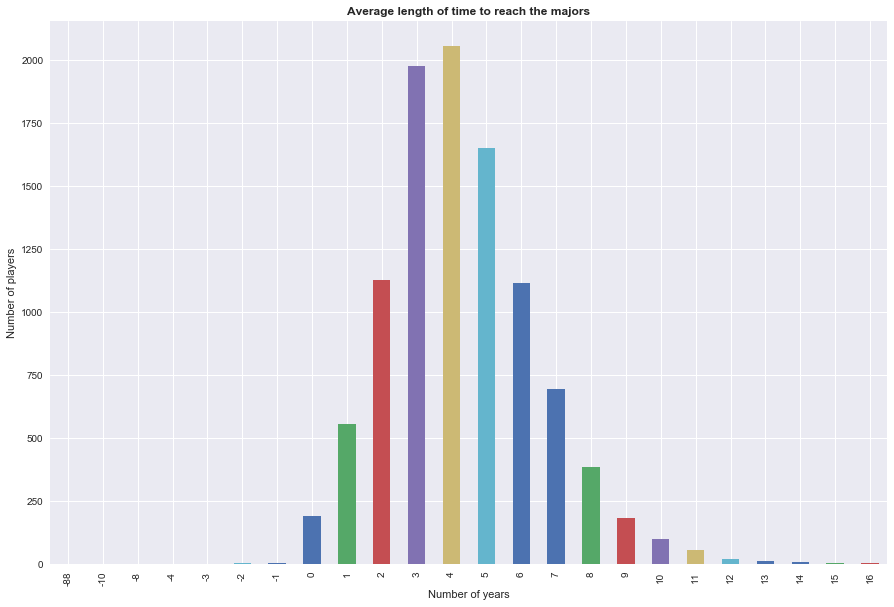

In [10]:
## Define additional variables

df_drafted_info['player_var'] = 1 # Add a variable to sum when columns are grouped
df_drafted_info['time_draft_mlb'] = df_drafted_info['mlb_start'] - df_drafted_info['draft_year']
df_drafted_info['time_in_mlb'] = df_drafted_info['mlb_end'] - df_drafted_info['mlb_start']
df_drafted_info['age_of_player'] = df_drafted_info['mlb_start'] - df_drafted_info['year_born']

plt.figure(figsize=(15, 10))
df_drafted_info['time_draft_mlb'].value_counts().sort_index().plot(kind='bar')
plt.title('Average length of time to reach the majors', fontweight='bold')
plt.xlabel('Number of years')
plt.ylabel('Number of players')

plt.show()

Negative values represent an error in the data (someone cannot reach the majors before they were drafted/signed), so we will remove those values. While data on the upper end may be unlikely, it's not implausible that someone could spend 10+ years in the minors -- just as they could spend 0 or 1 year -- before making their MLB debut, so we will keep those values.

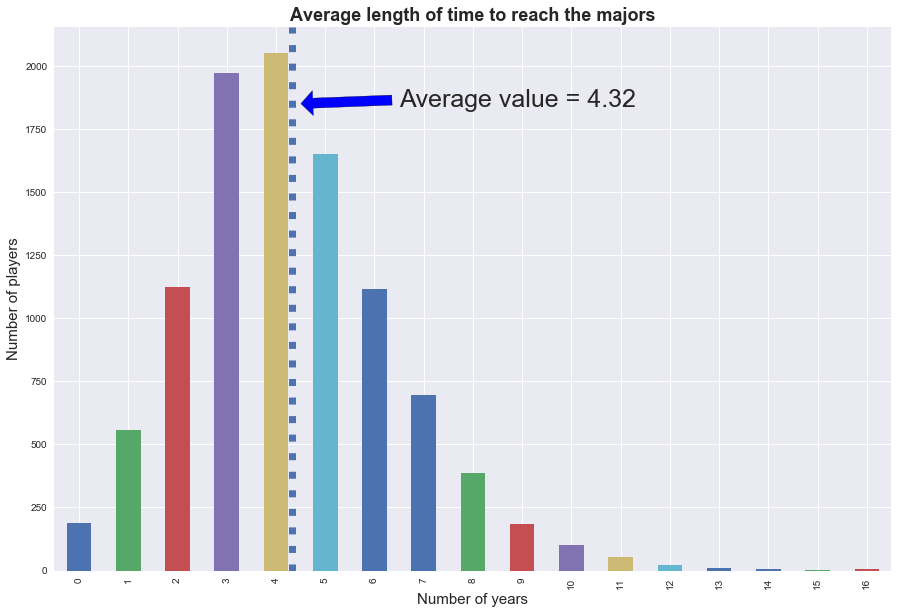

In [11]:
## Filter new dataframe to exclude non-negative values and re-plot the average time to reach the majors.

df_drafted_info = df_drafted_info[(df_drafted_info['time_draft_mlb'] >= 0)]

fig, ax = plt.subplots(figsize=(15, 10))

df_drafted_info['time_draft_mlb'].value_counts().sort_index().plot(kind='bar')
ax.set_title('Average length of time to reach the majors', fontweight='bold', fontsize=18)
ax.set_xlabel('Number of years', fontsize=15)
ax.set_ylabel('Number of players', fontsize=15)

ax.axvline(df_drafted_info['time_draft_mlb'].mean(), linestyle='dotted', linewidth=7)
ax.annotate('Average value = 4.32', fontsize=25, xy=(4.4, 1850), xytext=(6.5, 1840),
            arrowprops=dict(facecolor='blue', shrink=0.05, width=10, headwidth=25),
            )

plt.show()

The distribution centers at 3-5 years in the minor leagues before arriving at the majors for a typical player, with a long tail that extends as far as 16 years in the minor leagues before reaching the Majors.

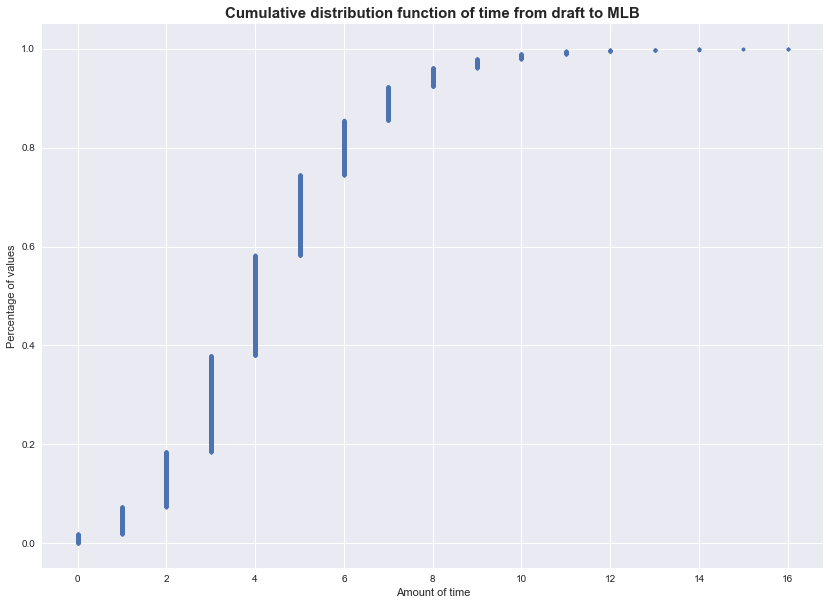

In [12]:
## Plot the distribution of values with a cumulative distribution function

num_years_x, num_years_y = dcst.ecdf(df_drafted_info['time_draft_mlb'])

plt.figure(figsize=(14, 10))
plt.plot(num_years_x, num_years_y, marker='.', linestyle='none')
plt.title('Cumulative distribution function of time from draft to MLB', fontweight='bold', fontsize=15)
plt.xlabel('Amount of time')
plt.ylabel('Percentage of values')

plt.show()

~60% of players reach the major leagues in 4 years or less, while just under 20% do so in 2 years or less. 

In [13]:
# Learn more about players that reached the MLB in 0 or 1 year

drafted_fast = df_drafted_info[df_drafted_info['time_draft_mlb'] <= 1]

dr_fast_mean = drafted_fast[drafted_fast['udfa_dummy'] == 0]['draft_round'].mean()
dn_fast_mean = drafted_fast[drafted_fast['udfa_dummy'] == 0]['draft_number'].mean()

dr_all_mean = df_drafted_info[df_drafted_info['udfa_dummy'] == 0]['draft_round'].mean()
dn_all_mean = df_drafted_info[df_drafted_info['udfa_dummy'] == 0]['draft_number'].mean()

print('The mean draft round for players fast to reach the MLB is: %.2f' %dr_fast_mean)
print('The mean draft round for all players that reached the MLB is: %.2f' % dr_all_mean)
print('The mean draft number for players fast to reach the MLB is: %.2f' %dn_fast_mean)
print('The mean draft number for all players that reached the MLB is: %.2f' % dn_all_mean)

The mean draft round for players fast to reach the MLB is: 4.13
The mean draft round for all players that reached the MLB is: 9.66
The mean draft number for players fast to reach the MLB is: 92.60
The mean draft number for all players that reached the MLB is: 257.97


In [14]:
# Continue drafted_fast exploratory analysis for average tenure of these players

tenure_fast = drafted_fast[drafted_fast['mlb_end'] <= 2017]['time_in_mlb'].mean()
all_time = df_drafted_info[df_drafted_info['mlb_end'] <= 2017]['time_in_mlb'].mean()

print("The mean time in the league for players fast to reach the MLB is: %.2f" %tenure_fast)
print("The mean time in the league for all players to reach the MLB is: %.2f" %all_time)

The mean time in the league for players fast to reach the MLB is: 7.62
The mean time in the league for all players to reach the MLB is: 5.30


Players that entered the league in one year or less show demonstrably better characteristics than the general MLB player set. They were drafted in a lower round and, on average, lasted longer in the major leagues.

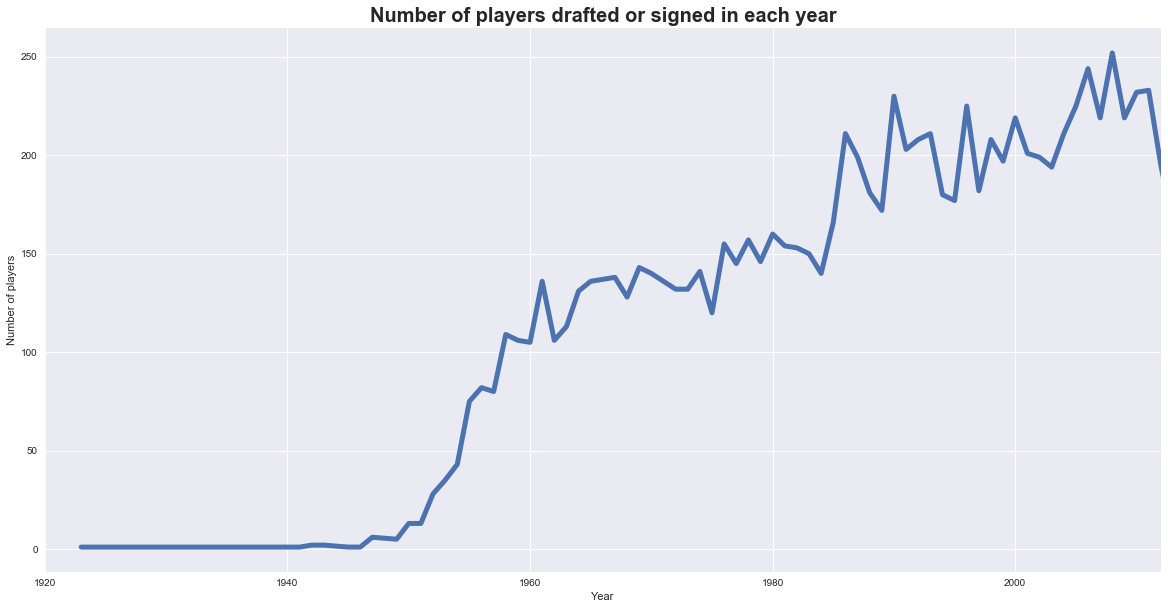

In [15]:
## Plot the distribution of draft year to see how we should filter the dataframe based on having reliable data

fig = plt.figure(figsize=(20, 10))

df_drafted_info['draft_year'].value_counts().sort_index().plot(linewidth=5)

plt.title('Number of players drafted or signed in each year', fontweight='bold', fontsize=20)
plt.ylabel('Number of players')
plt.xlabel('Year')
plt.xlim([1920, 2012]) # We limit the chart data to 2012 because many players drafted in 2013 or later have not yet
# reached maturity (as evidenced by , so the data for those years is not complete.

plt.show()

It looks like we start to get reliable data starting around 1960, so we will create a new filtered dataset with only data that is 1960 or later.

In [16]:
## Filter new dataframe to exclude values before 1960.

df_post60 = df_drafted_info[df_drafted_info['mlb_start'] >= 1960]

print('The original dataset had %i rows' %len(df_drafted_info))
print('The new dataset has %i rows' % df_post60.shape[0])

The original dataset had 10127 rows
The new dataset has 9956 rows


Even though we eliminated about 35 years of data, we only lost about 200 rows.

In [17]:
## Create second datframe that only includes 1990 or later to match Temperature dataset

df_post90 = df_drafted_info[df_drafted_info['mlb_start'] >= 1990]

In [18]:
## Group dataframe by MLB debut year to explore how time from draft to MLB has changed

df_mlb_debut = df_post60.groupby(by='mlb_start').mean()

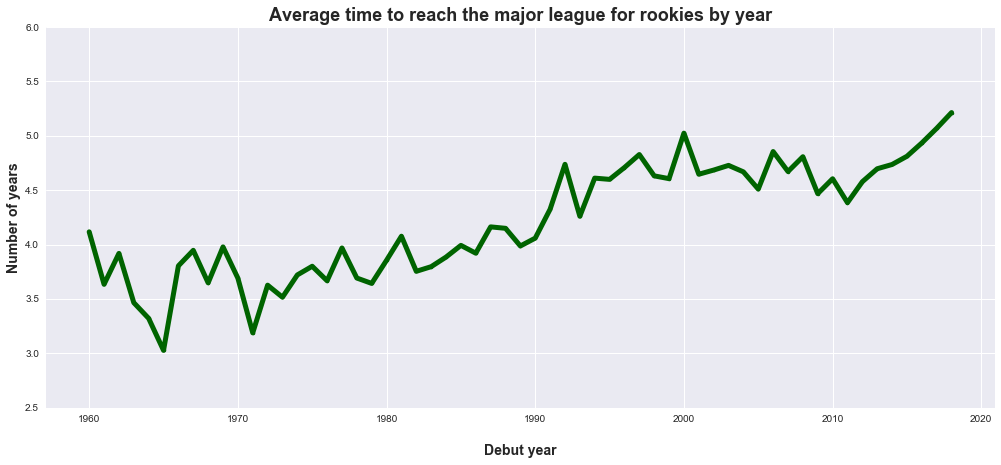

In [19]:
## Plot the yearly change in time_draft_mlb, which is the average amount of time between being drafted
## and making a major league debut

plt.figure(figsize=(17, 7))
plt.plot(df_mlb_debut.index, df_mlb_debut['time_draft_mlb'], marker='.', linewidth=5, color='darkgreen')
plt.title('Average time to reach the major league for rookies by year', fontweight='bold', fontsize=18)
plt.ylabel('Number of years', fontweight='bold', fontsize=14)
plt.xlabel('\nDebut year', fontweight='bold', fontsize=14)
plt.ylim([2.5, 6.0])

plt.show()

In [20]:
mean_time_2010 = float(df_mlb_debut[df_mlb_debut.index == 2010]['time_draft_mlb'])
mean_time_2017 = float(df_mlb_debut[df_mlb_debut.index == 2017]['time_draft_mlb'])

print('The mean time to the majors in 2010 was: %.2f years' %mean_time_2010)
print('The mean time to the majors in 2017 was: %.2f years' %mean_time_2017)

print('The percentage change from 2010-2017 = {0:.2f}%'.format(((mean_time_2017-mean_time_2010)/mean_time_2010)*100))

The mean time to the majors in 2010 was: 4.60 years
The mean time to the majors in 2017 was: 5.07 years
The percentage change from 2010-2017 = 10.07%


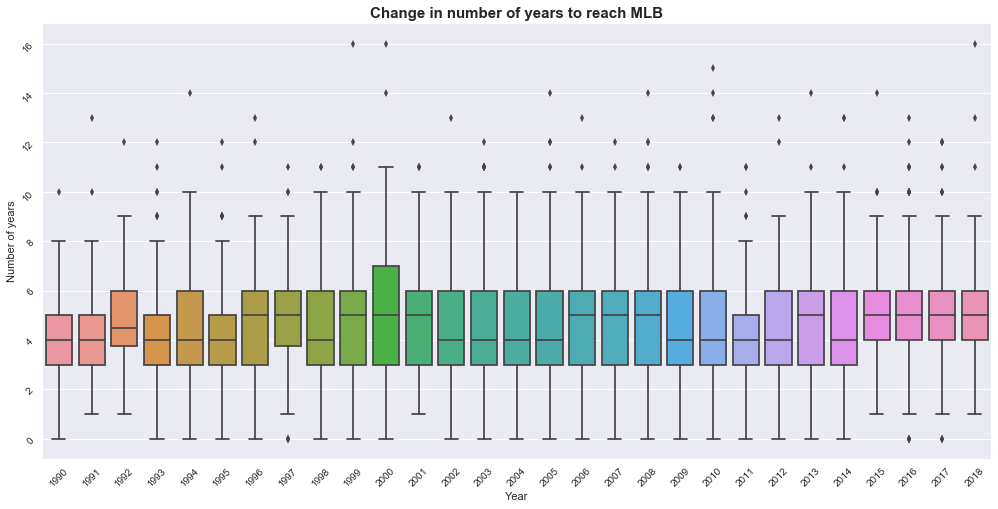

In [21]:
## Visualize change in distribution with boxplot

ax = plt.figure(figsize=(17, 8))
ax = sns.boxplot(x='mlb_start', y='time_draft_mlb', data=df_post90)
ax.set_ylabel('Number of years')
ax.set_xlabel('Year')
ax.set_title('Change in number of years to reach MLB', fontweight='bold', fontsize=15)
ax.tick_params(rotation=45)

plt.show()

It appears that the past 4 years have shown fairly consistent behavior, and all have a tighter interquartile range than all years except for 2011. This indicates that the majority of players are reaching the league within a more consistently small time frame (~1-9 years) as opposed to the 0-10 that is more common in most years.

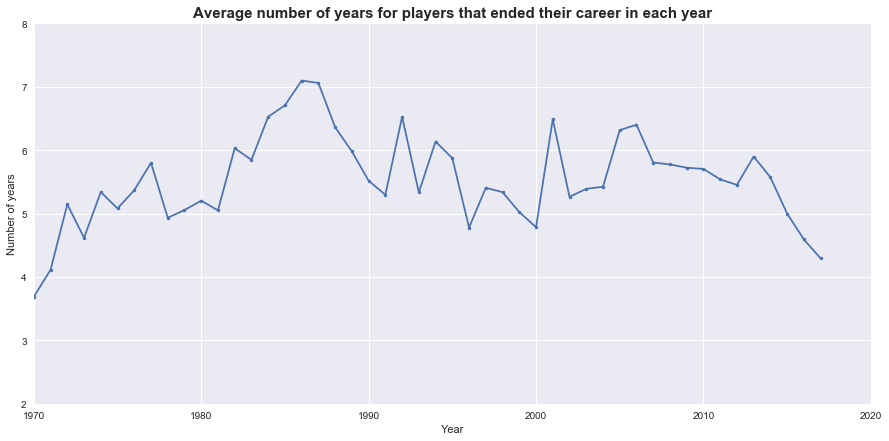

In [22]:
## Plot the average length of MLB career over time

career_over = df_post60[df_post60['mlb_end'] <= 2017]
career_over_grpd = career_over.groupby(by='mlb_end').mean()

fig = plt.figure(figsize=(15, 7))
plt.plot(career_over_grpd.index, career_over_grpd['time_in_mlb'], marker='.')

plt.xlabel('Year')
plt.ylabel('Number of years')
plt.title('Average number of years for players that ended their career in each year', fontweight='bold', fontsize=15)

plt.xlim([1970,2020])
plt.ylim([2, 8])

plt.show()

We're seeing a downward trend in length of career when grouped by the year in which a player ended their career. One possible explanation for this is that teams have less patience for players relative to the prior year. It's a "what can you do for me now?" environment with plenty of available players to take the place of underperformers given the depth of most minor league systems.

I'd also like to do an analysis on how the number of rookies per year entering the league has changed over the time period. While we could take the absolute number, this could be misleading because the MLB has expanded since 1960, so the number should increase without taking into account normalizing factors. Therefore, we will need to create a "rookies per team" variable for each year.

To do this, we need to know how many teams there were each year, then divide the number of new players (player_var) by the number of teams.

In order to generate the number of teams for each year, I have done a scrape of the Major League Baseball wikipedia page to get the team and its original year founded (as opposed to when its been re-incorporated or re-named, since this doesn't change the number of teams in the league).

I will now read in the new data set, count the number of teams per year, then append it to the df_yr data frame that will be subsequently made.

In [23]:
## Read in the team and founding years dataset

df_team = pd.read_csv(r'C:\Users\jbean\Dropbox\Other\Python\baseballdatabank-2017.1\Project_Quality\wiki_team_scrape.csv', index_col=0)
  
yr_founded = list(df_team.year_founded)
unique_yr = sorted(list(set(yr_founded)), key=int)

print('MLB expansion years where teams were added: %s' %unique_yr)

MLB expansion years where teams were added: [1871, 1874, 1882, 1883, 1884, 1901, 1961, 1962, 1969, 1977, 1993, 1998]


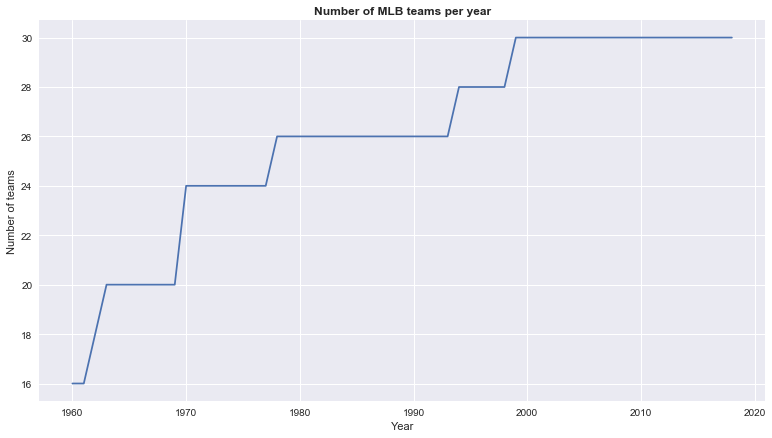

In [24]:
## Create a list of the number of teams per year between 1960 and 2018 and plot the values to ensure accuracy

num_teams = []

for i in range(1960, 2019):
    
    counter = 0
    
    for yr in yr_founded:
        
        if i > yr: # Logic for whether the team has already been founded in the year, and if yes, add 1 to the counter of teams/yr
        
            counter +=1
            
    num_teams.append(counter)

plt.figure(figsize=(13,7))
plt.plot(range(1960, 2019), num_teams)
plt.xlabel('Year')
plt.ylabel('Number of teams')
plt.title('Number of MLB teams per year', fontweight='extra bold')

plt.show()

In [25]:
## Number of rookies per year

df_yr = df_post60.groupby(by='mlb_start').sum() # Use the post 1960 dataset for accurate data

df_yr['num_teams'] = num_teams # Add our number of teams variable
df_yr['rook_per_team'] = df_yr['player_var'] / df_yr['num_teams']

cols = ['udfa_dummy','draft_round','draft_number','player_var',
        'time_draft_mlb','time_in_mlb','age_of_player','num_teams','rook_per_team']

df_yr = df_yr[cols]

df_yr.sample(5)

,udfa_dummy,draft_round,draft_number,player_var,time_draft_mlb,time_in_mlb,age_of_player,num_teams,rook_per_team
mlb_start,,,,,,,,,
2007,53,1424,42258,210,981,951,5231,30,7.000000
1991,29,1405,34956,191,826,1152,4718,26,7.346154
2015,65,1803,55739,255,1227,502,6375,30,8.500000
2006,66,1478,43705,221,1073,1172,5480,30,7.366667
2009,55,1502,45042,203,907,933,5083,30,6.766667


In [26]:
## I'm going to filter out the 2018 data because it's not complete and therefore not
## comparable to the other data points

df_yr = df_yr[df_yr.index < 2018]

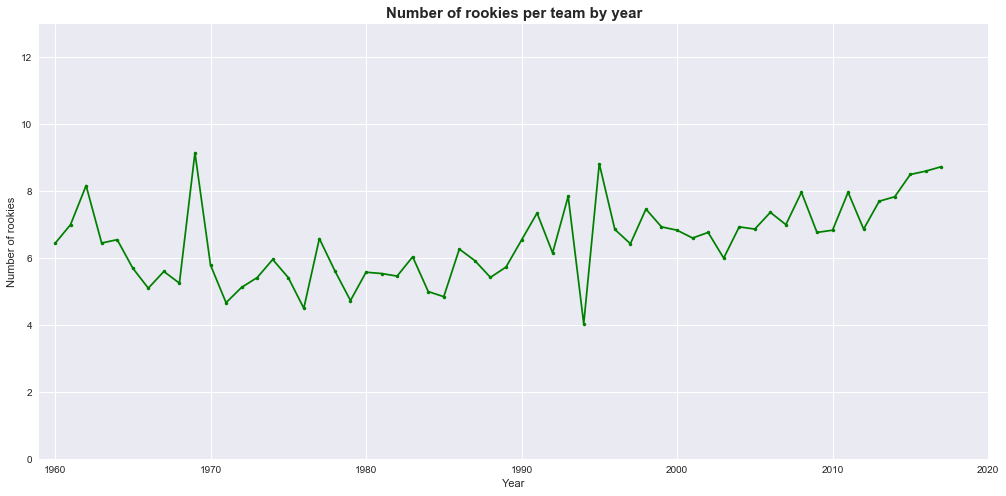

In [27]:
## Plot the change in rookies per team

fig = plt.figure(figsize=(17, 8))

plt.plot(df_yr.index, df_yr['rook_per_team'], marker='.', color='green')
plt.title('Number of rookies per team by year', fontweight='bold', fontsize=15)
plt.ylim([0,13])
plt.xlim([1959, 2020])
plt.ylabel('Number of rookies')
plt.xlabel('Year')

plt.show()

Though the varialbe is volatile between ranges of ~4 and ~9, the data does show a steady upward trend over the past 5 years and is approaching a 50-year high.

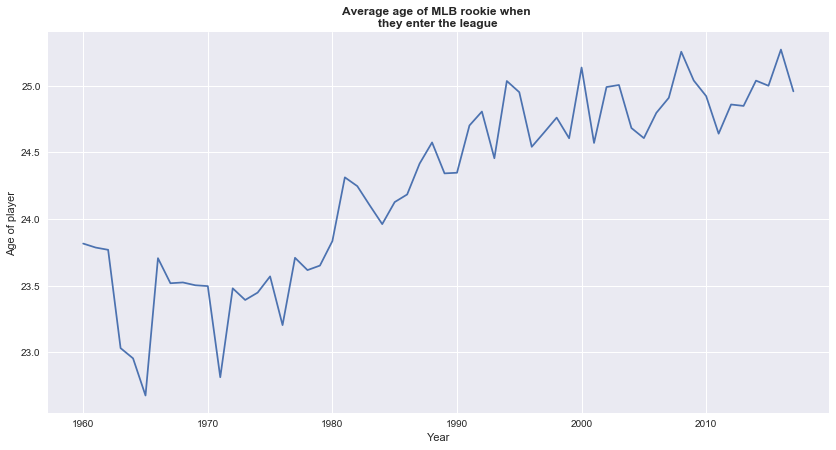

In [28]:
## Average age of rookies entering MLB

df_yr['average_age'] = df_yr['age_of_player'] / df_yr['player_var']

plt.figure(figsize=(14, 7))
df_yr['average_age'].plot()
plt.xlabel('Year')
plt.ylabel('Age of player')
plt.title('Average age of MLB rookie when \nthey enter the league', fontweight='bold')

plt.show()

Likely in tandem with the other variables we've seen, such as elongating the time to reach the league, the average age of rookies is increasing. This could also be influenced by whether there are more players foregoing the MLB amateur draft and instead attending college, then being drafted out of college, but we didn't look at that variable as a part of this analysis.

In [29]:
## Data frame of drafted players only (i.e. eliminate the undrafted free agents)

df_drafted = df_post60[df_post60['udfa_dummy'] == 0]

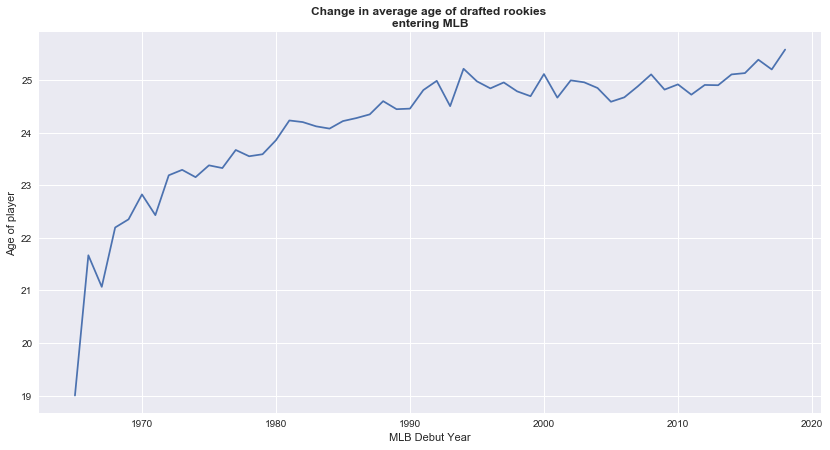

In [30]:
## Plot the change in average age number for rookies that were drafted (earlier we looked at all players)

df_draft_grp = df_drafted.groupby(by='mlb_start').sum()
df_draft_grp['avg_age'] = df_draft_grp['age_of_player'] / df_draft_grp['player_var']

plt.figure(figsize=(14, 7))
df_draft_grp['avg_age'].plot()
plt.title('Change in average age of drafted rookies \nentering MLB', fontweight='bold')
plt.xlabel('MLB Debut Year')
plt.ylabel('Age of player')

plt.show()

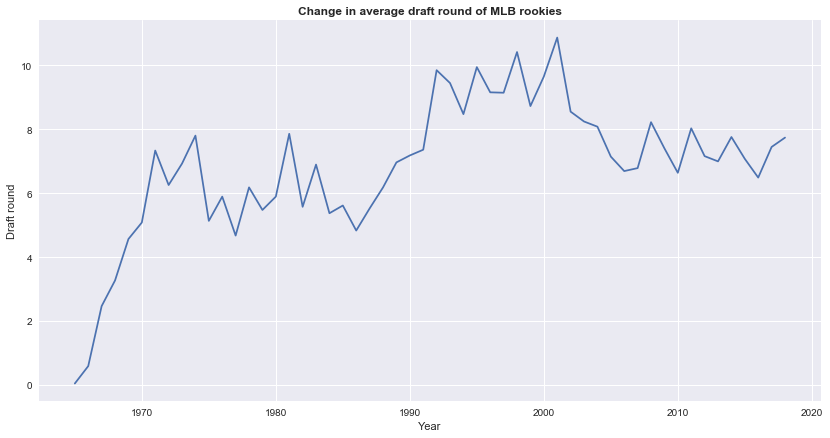

In [31]:
## Plot the average draft round of players entering the league

plt.figure(figsize=(14, 7))
df_mlb_debut[df_mlb_debut.index > 1964]['draft_round'].plot()
plt.title('Average draft round of MLB rookies')
plt.ylabel('Draft round')
plt.xlabel('Year')
plt.title('Change in average draft round of MLB rookies', fontweight='bold')

plt.show()

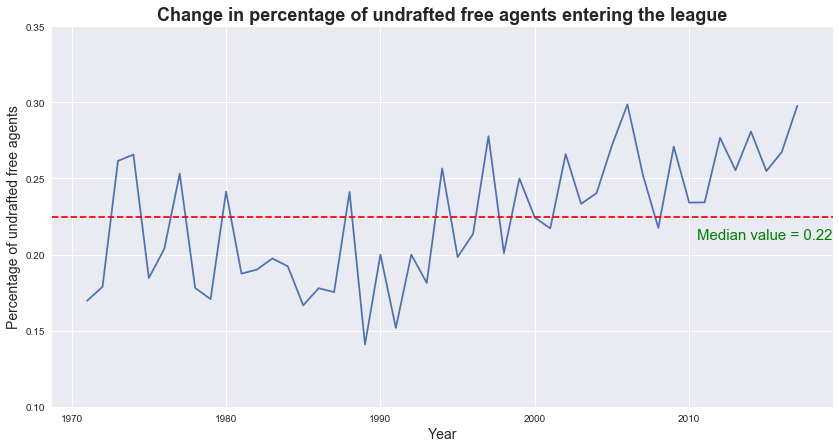

In [32]:
## Plot the percentage of undrafted free agents entering the league

fig, ax = plt.subplots(figsize=(14, 7))
df_mlb_debut[(df_mlb_debut.index > 1970) & (df_mlb_debut.index < 2018)]['udfa_dummy'].plot()
plt.xlabel('Year', fontsize=14)
plt.ylabel('Percentage of undrafted free agents', fontsize=14)
plt.title('Change in percentage of undrafted free agents entering the league', fontweight = 'bold', fontsize=18)
plt.ylim([0.1, 0.35])
ax.axhline(df_mlb_debut[(df_mlb_debut.index > 1970) & (df_mlb_debut.index < 2018)]['udfa_dummy'].median(), 
           color='red', linestyle='dashed')

ax.annotate('Median value = %.2f' %df_mlb_debut[(df_mlb_debut.index > 1970) & 
                                                (df_mlb_debut.index < 2018)]['udfa_dummy'].median(), (2010.5, 0.21), size=15, color='green')

plt.show()

We'll also run a brief analysis to look for whether the length of time to reach the majors differs by position, and whether this should be a variable that we segment by. Since some players are listed with multiple positions, we will have to clean the data by:

1) Splitting the values and considering the first a "primary" position and the second a "secondary" position

2) Creating a condensed grouped variable for similar position types

In [33]:
df_post60.position.unique()

array(['P', '1B-OF', '1B', 'CF-LF', 'SS-2B', 'OF', '2B', 'CF-RF', 'LF',
       '2B-CF', 'SS', '1B-C', '3B-2B', 'C', 'OF-2B', 'SS-3B', '3B',
       'LF-1B', 'LF-RF', '2B-3B', 'RF-1B', '1B-LF', 'RF', 'OF-3B', '1B-3B',
       '2B-OF', 'CF', 'RF-LF', 'LF-OF', 'RF-CF', 'LF-2B', 'LF-CF', '3B-P',
       '2B-SS', 'CF-OF', '3B-1B', 'RF-OF', '3B-SS', 'IF', '3B-OF', 'OF-SS',
       'C-3B', 'OF-1B', '3B-CF', 'DH', '2B-C', 'C-OF', '2B-RF', 'C-1B',
       '3B-RF', 'RF-3B', '2B-1B', '1B-RF', 'H', '1B-2B', '3B-C', '1B-SS',
       'LF-3B', 'SS-LF', 'OF-IF', 'LF-SS', 'RF-2B', 'C-LF', 'OF-DH',
       'DH-C', 'OF-C', 'DH-1B', '1B-DH', 'CF-1B', 'CF-3B', '3B-LF', 'LF-C',
       '2B-LF', 'C-2B', 'P-OF', 'P-LF', 'IF-OF', 'SS-CF', 'DH-3B', 'LF-DH',
       'SS-OF', 'C-DH', 'DH-LF', 'CF-2B', 'CF-SS', '3B-DH', 'SS-1B'], dtype=object)

In [34]:
# Create better variables for position

condensed_dict = {
                 'P': 'P',
                 '1B': 'IF',
                 '2B': 'IF',
                 '3B' : 'IF',
                 'SS': 'IF',
                 'IF':'IF',
                 'DH':'Other',
                 'H':'Other',
                 'LF':'OF',
                 'RF':'OF',
                 'CF':'OF',
                 'OF':'OF',
                 'C':'C'
                 }

df_post60['primary_position'] = [i.split('-')[0] if len(i) > 2 else i for i in df_post60.position]
df_post60['secondary_position'] = [i.split('-')[1] if len(i) > 2 else 'None' for i in df_post60.position]
df_post60['primary_pos_condensed'] = [condensed_dict.get(i) for i in df_post60['primary_position']]

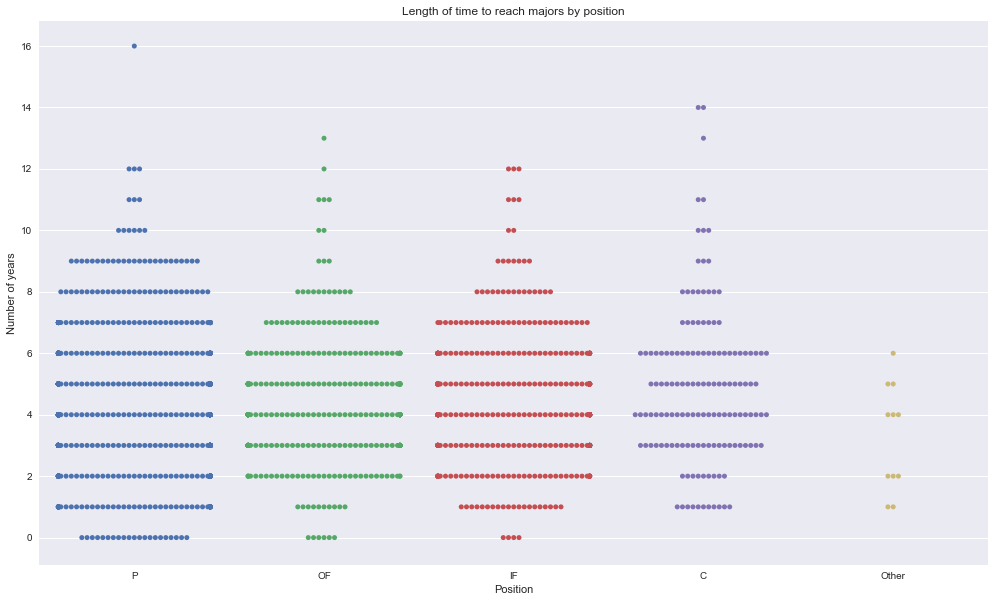

In [35]:
## Visualize if there's a difference by position in time to the major leagues

ax = plt.figure(figsize=(17, 10))

ax = sns.swarmplot(x="primary_pos_condensed", y="time_draft_mlb", data=df_post60.sample(2000))
ax.set_title('Length of time to reach majors by position')
ax.set_ylabel('Number of years')
ax.set_xlabel('Position')

plt.show()

There isn't a huge difference by position. It looks like pitchers are the most likely to be able to reach the major leagues quickly, but the center of the distribution appears fairly similar for the positions overall.

# Conclusion

And that concludes our initial analyses! Our high level findings are that trended time series data across our studied variables appear to be showing changes over the past couple years, which corresponds to the declining attendance per game.

We can't say with conviction that the change is causing the change, nor that the quality of player has necessarily changed (demographics do not tell us about quality), simply that the path to the league appears to be different and the team composition is likewise changing.